In [5]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
import segmentation_models_pytorch as smp
from PIL import Image

In [24]:
# !pip install segmentation_models_pytorch



In [6]:
%load_ext autoreload
%autoreload 2

import os, gdown
from glob import glob
def get_data(path, ds_name = "archive"):
    if os.path.isdir(path): print("data is here"); pass

    # If the pretrained file has not been downloaded yet
    else:
        os.makedirs(path, exist_ok=True)
        # Url of the checkpoint
        url="https://drive.google.com/file/d/18w1Ec9Pnh4mImU6EWoGEEPPXqko4QcvK/view?usp=drive_link" if ds_name=="archive" else None
        # get file id
        ds_id = url.split("/")[-2]
        # Set prefix
        prefix=  "https://drive.google.com/uc?/export=download&id="
        # Download and checkpoint
        gdown.download(prefix+ds_id, path, quiet=False)
        folder_file = glob(f"{path}/*")
        for file_path in folder_file:

            os.system(f"unzip {file_path} -d {path}")
            os.remove(file_path)

get_data(path = "data",ds_name = "archive" )

Downloading...
From: https://drive.google.com/uc?/export=download&id=18w1Ec9Pnh4mImU6EWoGEEPPXqko4QcvK
To: /content/data
100%|██████████| 112M/112M [00:03<00:00, 37.0MB/s]


In [7]:

import albumentations as A
def get_transformation(size):
    return [A.Compose([A.Resize(size, size),
                      A.HorizontalFlip(0.5),
                      A.VerticalFlip(0.5),
                       A.GaussNoise(0.2)], is_check_shapes=False),
           A.Compose([A.Resize(size, size)], is_check_shapes=False)]
tr_ts, ts_ts = get_transformation(size = 320)
tr_ts, ts_ts


(Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
   HorizontalFlip(always_apply=0.5, p=0.5),
   VerticalFlip(always_apply=0.5, p=0.5),
   GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.2), per_channel=True, mean=0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False),
 Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False))

In [11]:

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from glob import glob
import torch, cv2


class CustomDataset(Dataset):
    def __init__(self, root, transformations =None, im_files = [".jpg", ".png", ".jpeg"]):
        super().__init__()
        self.transformations = transformations
        self.tensorsize = T.Compose([T.ToTensor()])

        self.im_path = sorted(glob(f"{root}/Image/*[{im_file for im_file in im_files}]"))
        self.gt_path = sorted(glob(f"{root}/Mask/*[{im_file for im_file in im_files}]"))




    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):


        try: cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        except: print(self.im_path[idx])
        im = cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(self.gt_path[idx]), cv2.COLOR_BGR2GRAY)


#         Example of resizing gt to match im shape



        image_path = "data/Image/0.jpg"
        mask_path = "data/Mask/0.png"

# #         Check if the files exist before attempting to delete
#         if os.path.exists(image_path):
#             os.remove(image_path)
#             print(f"Image file '{image_path}' deleted successfully.")
#         else:
#             print(f"Image file '{image_path}' not found.")

#         if os.path.exists(mask_path):
#             os.remove(mask_path)
#             print(f"Mask file '{mask_path}' deleted successfully.")
#         else:
#             print(f"Mask file '{mask_path}' not found.")




        if self.transformations is not None:
            transformed =self.transformations(image = im, mask =gt)
            im = transformed['image']
            gt = transformed['mask']


        im = self.tensorsize(im)
        gt = torch.tensor(gt>128).long()


        return im, gt

ds = CustomDataset(root="data", transformations=ts_ts)

ds[18]
# print(ds[2][1].shape)




(tensor([[[0.5176, 0.5176, 0.5059,  ..., 0.0392, 0.6902, 0.4667],
          [0.5176, 0.5176, 0.5098,  ..., 0.1686, 0.4039, 0.3098],
          [0.5176, 0.5176, 0.5098,  ..., 0.5373, 0.4863, 0.5098],
          ...,
          [0.0941, 0.0000, 0.0118,  ..., 0.5725, 0.5725, 0.5725],
          [0.0549, 0.0314, 0.0118,  ..., 0.5725, 0.5725, 0.5725],
          [0.0000, 0.0078, 0.0588,  ..., 0.5725, 0.5725, 0.5725]],
 
         [[0.6039, 0.6039, 0.6078,  ..., 0.1961, 0.8196, 0.5804],
          [0.6039, 0.6039, 0.6078,  ..., 0.3294, 0.5373, 0.4235],
          [0.6039, 0.6039, 0.6078,  ..., 0.6902, 0.6196, 0.6235],
          ...,
          [0.3020, 0.1804, 0.1412,  ..., 0.4118, 0.4118, 0.4118],
          [0.2196, 0.1922, 0.1098,  ..., 0.4118, 0.4118, 0.4118],
          [0.1333, 0.0863, 0.1725,  ..., 0.4118, 0.4118, 0.4118]],
 
         [[0.6941, 0.6941, 0.6941,  ..., 0.2314, 0.8392, 0.5804],
          [0.6941, 0.6941, 0.6941,  ..., 0.3608, 0.5608, 0.4353],
          [0.6941, 0.6941, 0.6941,  ...,

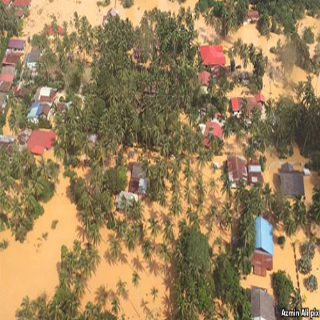

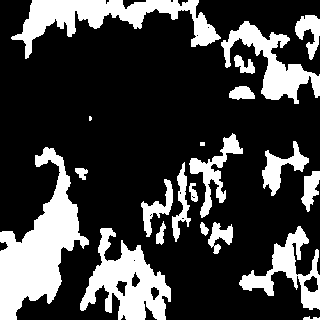

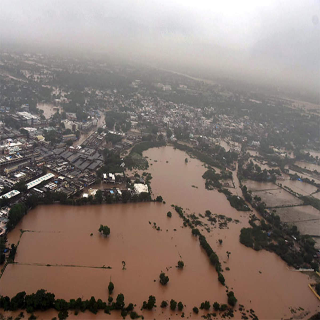

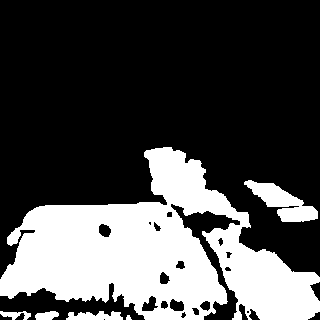

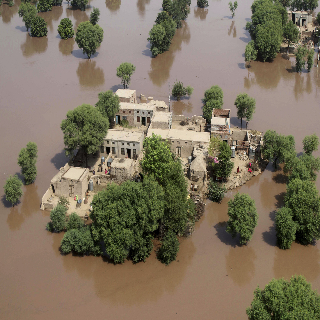

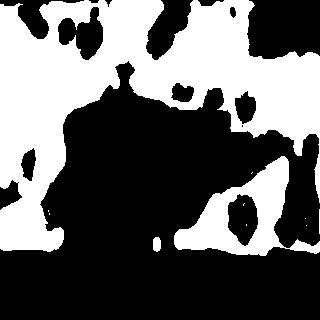

In [12]:

import numpy as np
from PIL import Image
def tn_2_np(t):
    return (t*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if len(t)==3 else (t*255).detach().cpu().numpy().astype(np.uint8)

for idx, data in enumerate(ds):
    if idx ==3: break

    im, gt =data
    display(Image.fromarray(tn_2_np(im)))
    display(Image.fromarray(tn_2_np(gt)))

In [13]:

def get_dls(root, transformations, bs, split = [0.7, 0.15, 0.15]):

    ds = CustomDataset(root=root, transformations=transformations)
    tr_length = len(ds)

    tr_len = int(split[0]* tr_length)
    vl_len = int(split[1] * tr_length)
    ts_len = tr_length - tr_len-vl_len

    tr_ds , val_ds, test_ds = random_split(ds, [tr_len, vl_len, ts_len])

    print(f"Train dataset data soni      -> {len(tr_ds)}")
    print(f"Validation dataset data soni -> {len(val_ds)}")
    print(f"Test dataset data soni       -> {len(test_ds)}")




    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=0)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=0)
    test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)


    return tr_dl, val_dl , test_dl

tr_dl, val_dl , test_dl = get_dls(root='data', transformations=ts_ts, bs=2)

Train dataset data soni      -> 202
Validation dataset data soni -> 43
Test dataset data soni       -> 44


In [14]:
model = smp.Unet(encoder_name='mobilenet_v2', classes=2, encoder_depth =5,
                encoder_weights = 'imagenet', activation=None, decoder_channels = [256, 128, 64, 32, 16])
model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 153MB/s]


Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003)
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [16]:
import numpy as np, time, os
from tqdm import tqdm
# Metrica

class Metrics():
    def __init__(self, pred, gt, loss_fn,eps = 3e-4, num_class =2):
        self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim =1), dim=1)
        self.gt = gt
        self.loss_fn = loss_fn
        self.pred_ = pred
        self.num_class = num_class
        self.eps=eps

    def to_contiguos(self, inp): return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():

            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum())/float(match.numel())

    def mIoU(self):

        with torch.no_grad():

            pred, gt = self.to_contiguos(self.pred), self.to_contiguos(self.gt)

            Iou_num_class =[]

            for a in range(self.num_class):
                match_pred = pred ==a
                match_gt = gt ==a
#                 print(type(match_gt))
                if match_gt.long().sum().item() ==0: Iou_num_class.append(np.nan)
                else:

                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersection)/(union+ self.eps)

                    Iou_num_class.append(iou)

                return np.nanmean(Iou_num_class)

    def loss(self):  return self.loss_fn(self.pred_, self.gt)


# Train

def train(model, tr_dl, val_dl, epochs, device, loss_fn, opt, save_prefix ):
    tr_loss, tr_pa, tr_iou = [],[],[]
    val_loss, val_pa, val_iou= [],[],[]
    tr_len, val_len = len(tr_dl), len(val_dl)

    best_loss =np.inf
    decrease, not_improve, early_stop_threshold = 1, 0, 5
    os.makedirs("modellar", exist_ok=True)

    model.to(device)

    print("Training is starting...")

    for epoch in range(1, epochs+1):
        tr_loss_, tr_pa_, tr_iou_ = 0,0,0
        model.train()

        print(f"{epoch}- epoch training is starting ...")

        for idx, batch in enumerate(tqdm(tr_dl)):

            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            met = Metrics(pred, gt, loss_fn)

            loss_= met.loss()

            tr_iou_+=met.mIoU()
            tr_pa_+=met.PA()
            tr_loss_+=loss_.item()

            opt.zero_grad()
            loss_.backward()
            opt.step()

        print(f"{epoch}- epoch validation is starting ...")

        model.eval()
        val_loss_, val_pa_, val_iou_ = 0,0,0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred, gt, loss_fn)

                val_loss_ += met.loss().item()
                val_iou_+= met.mIoU()
                val_pa_+= met.PA()


        print(f"{epoch}- epoch training is fineshed\n")

        tr_iou_ /= tr_len
        tr_loss_ /=tr_len
        tr_pa_ /=tr_len

        val_iou_ /= val_len
        val_pa_ /= val_len
        val_loss_ /= val_len


        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\n{epoch}-epoch train jarayoni natijalari: \n")

        print(f"Train error          =>{tr_loss_:3f}")
        print(f"Train PA             =>{tr_pa_:3f}")
        print(f"Train mIoU           =>{tr_iou_:3f}\n")

        print(f"Validation error      =>{val_loss_:3f}")
        print(f"Validation PA         =>{val_pa_:3f}")
        print(f"Validation mIoU       =>{val_iou_:3f}")


        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)
        tr_loss.append(tr_loss_)

        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        val_loss.append(val_loss_)

        if val_loss_< best_loss:

            print(f"Error is decreased from {best_loss:.3f}  to {val_loss_:.3f}!")
            best_loss=val_loss_
            decrease+=1
            if decrease%2==0:

                print("The model is saved with the lowest error ...")
                torch.save(model, f"modellar/{save_prefix}_best_model.pt")
        if val_loss_ > best_loss:
            not_improve += 1
            best_loss = val_loss_
            print(f"  Error {not_improve} did not decrease during the epoch!")
            if not_improve == early_stop_threshold:
                print(f"Stop training because of  Error did not decrease during {early_stop_threshold}  epoch ")
                break

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa": val_pa}




In [17]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=10,
              device = device, loss_fn = loss_fn, opt = optimizer, save_prefix = "FOODS")

Training is starting...
1- epoch training is starting ...


100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


1- epoch validation is starting ...


100%|██████████| 22/22 [00:03<00:00,  7.00it/s]


1- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1-epoch train jarayoni natijalari: 

Train error          =>0.448103
Train PA             =>0.796715
Train mIoU           =>0.705734

Validation error      =>0.376871
Validation PA         =>0.842217
Validation mIoU       =>0.794589
Error is decreased from inf  to 0.377!
The model is saved with the lowest error ...
2- epoch training is starting ...


100%|██████████| 101/101 [00:20<00:00,  4.91it/s]


2- epoch validation is starting ...


100%|██████████| 22/22 [00:02<00:00,  9.30it/s]


2- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2-epoch train jarayoni natijalari: 

Train error          =>0.388233
Train PA             =>0.831691
Train mIoU           =>0.748691

Validation error      =>0.303672
Validation PA         =>0.876882
Validation mIoU       =>0.830885
Error is decreased from 0.377  to 0.304!
3- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.71it/s]


3- epoch validation is starting ...


100%|██████████| 22/22 [00:03<00:00,  6.30it/s]


3- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3-epoch train jarayoni natijalari: 

Train error          =>0.392400
Train PA             =>0.827619
Train mIoU           =>0.743813

Validation error      =>0.401513
Validation PA         =>0.800667
Validation mIoU       =>0.761001
  Error 1 did not decrease during the epoch!
4- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.81it/s]


4- epoch validation is starting ...


100%|██████████| 22/22 [00:02<00:00,  9.27it/s]


4- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4-epoch train jarayoni natijalari: 

Train error          =>0.377940
Train PA             =>0.839969
Train mIoU           =>0.758769

Validation error      =>0.290260
Validation PA         =>0.888819
Validation mIoU       =>0.845798
Error is decreased from 0.402  to 0.290!
The model is saved with the lowest error ...
5- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.77it/s]


5- epoch validation is starting ...


100%|██████████| 22/22 [00:03<00:00,  5.96it/s]


5- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5-epoch train jarayoni natijalari: 

Train error          =>0.340629
Train PA             =>0.858448
Train mIoU           =>0.781902

Validation error      =>0.282345
Validation PA         =>0.896868
Validation mIoU       =>0.851327
Error is decreased from 0.290  to 0.282!
6- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.81it/s]


6- epoch validation is starting ...


100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


6- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

6-epoch train jarayoni natijalari: 

Train error          =>0.356792
Train PA             =>0.851579
Train mIoU           =>0.772130

Validation error      =>0.263207
Validation PA         =>0.893790
Validation mIoU       =>0.854646
Error is decreased from 0.282  to 0.263!
The model is saved with the lowest error ...
7- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.84it/s]


7- epoch validation is starting ...


100%|██████████| 22/22 [00:03<00:00,  6.56it/s]


7- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

7-epoch train jarayoni natijalari: 

Train error          =>0.341957
Train PA             =>0.858949
Train mIoU           =>0.780218

Validation error      =>0.355069
Validation PA         =>0.845073
Validation mIoU       =>0.777955
  Error 2 did not decrease during the epoch!
8- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.72it/s]


8- epoch validation is starting ...


100%|██████████| 22/22 [00:02<00:00,  8.97it/s]


8- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

8-epoch train jarayoni natijalari: 

Train error          =>0.320731
Train PA             =>0.866253
Train mIoU           =>0.791219

Validation error      =>0.235845
Validation PA         =>0.909335
Validation mIoU       =>0.869522
Error is decreased from 0.355  to 0.236!
9- epoch training is starting ...


100%|██████████| 101/101 [00:17<00:00,  5.82it/s]


9- epoch validation is starting ...


100%|██████████| 22/22 [00:02<00:00,  7.38it/s]


9- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

9-epoch train jarayoni natijalari: 

Train error          =>0.315463
Train PA             =>0.872886
Train mIoU           =>0.796672

Validation error      =>0.267077
Validation PA         =>0.888666
Validation mIoU       =>0.846216
  Error 3 did not decrease during the epoch!
10- epoch training is starting ...


100%|██████████| 101/101 [00:18<00:00,  5.61it/s]


10- epoch validation is starting ...


100%|██████████| 22/22 [00:02<00:00,  9.08it/s]


10- epoch training is fineshed


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

10-epoch train jarayoni natijalari: 

Train error          =>0.300992
Train PA             =>0.877547
Train mIoU           =>0.805656

Validation error      =>0.242799
Validation PA         =>0.899600
Validation mIoU       =>0.852544
Error is decreased from 0.267  to 0.243!
The model is saved with the lowest error ...


In [18]:
result

{'tr_loss': [0.44810263694512964,
  0.3882328774964455,
  0.3923998892602354,
  0.3779398112899006,
  0.3406285596365976,
  0.35679168172992104,
  0.34195721724835954,
  0.32073127057882816,
  0.3154629377445372,
  0.3009916079221385],
 'tr_iou': [0.7057339294362662,
  0.7486909750317068,
  0.7438134896008228,
  0.7587693989104795,
  0.7819018673557624,
  0.7721296523612506,
  0.7802178719797138,
  0.7912189532211201,
  0.7966723410206248,
  0.8056561473794117],
 'tr_pa': [0.7967151724938116,
  0.8316911935334157,
  0.8276188795637376,
  0.8399693011293317,
  0.858447652382426,
  0.8515794689820545,
  0.858949131729579,
  0.8662528039913368,
  0.8728858872215347,
  0.8775470877165841],
 'val_loss': [0.3768713663924824,
  0.3036719039082527,
  0.4015131768855182,
  0.2902598130432042,
  0.2823445844379338,
  0.26320733333175833,
  0.3550691455602646,
  0.23584451187740674,
  0.2670773206786676,
  0.24279910867864435],
 'val_iou': [0.7945886919291574,
  0.8308849304402144,
  0.7610014685

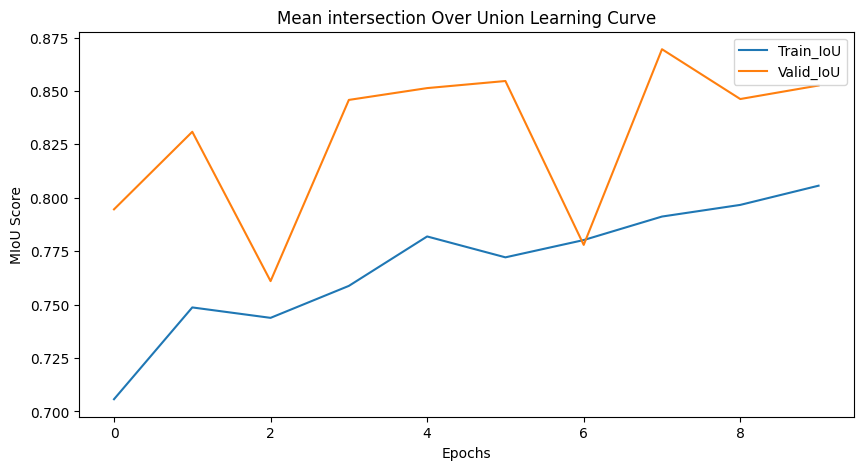

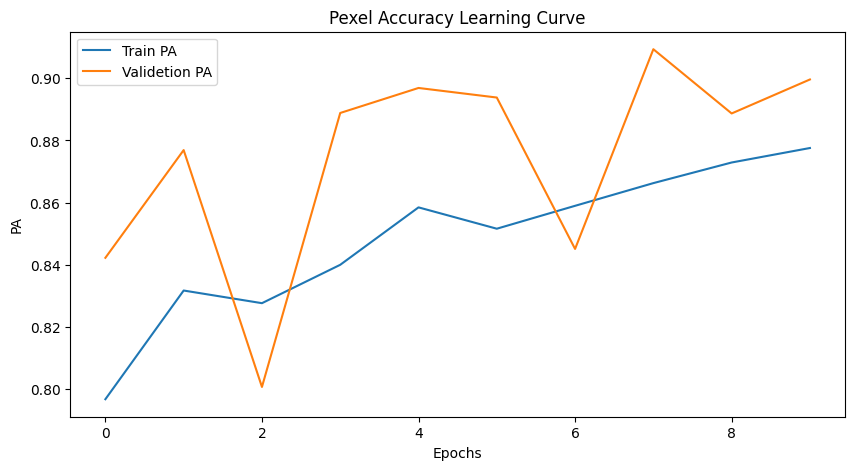

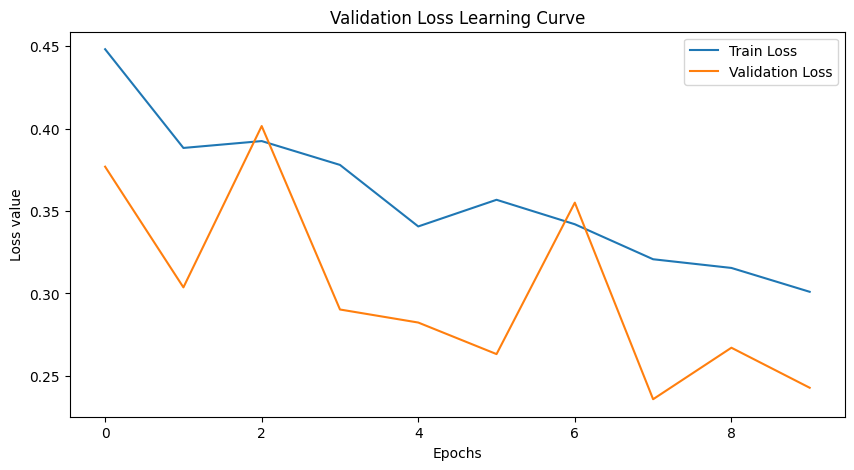

In [21]:
import matplotlib.pyplot as plt

class Plot():
    def __init__(self, res):


        plt.figure(figsize =(10,5))
        plt.plot(res['tr_iou'], label = 'Train_IoU')
        plt.plot(res['val_iou'], label = 'Valid_IoU')
        plt.title("Mean intersection Over Union Learning Curve")
        plt.xlabel('Epochs')
        plt.ylabel('MIoU Score')
        plt.legend()
        plt.show()

        plt.figure(figsize = (10, 5))
        plt.plot(res['tr_pa'], label = "Train PA")
        plt.plot(res['val_pa'], label = "Validetion PA")
        plt.title("Pexel Accuracy Learning Curve")
        plt.xlabel('Epochs')
        plt.ylabel("PA")
        plt.legend()
        plt.show()

        plt.figure(figsize = (10, 5))
        plt.plot(res['tr_loss'], label = "Train Loss")
        plt.plot(res['val_loss'], label = "Validation Loss")
        plt.title("Validation Loss Learning Curve")
        plt.xlabel('Epochs')
        plt.ylabel("Loss value")
        plt.legend()
        plt.show()
Plot(result)




In [22]:
def inference(dl, model, device):

    count = 1

    for idx, batch in enumerate(dl):

        if idx == 2: break
        im, gt = batch

        pred = model(im.to(device))

        plt.figure(figsize = (14, 10))

        plt.subplot(2, 3, count)
        plt.imshow(tn_2_np(im.squeeze(0)))
        plt.axis("off")
        plt.title("Original Image")

        count += 1

        plt.subplot(2, 3, count)
        plt.imshow(gt.squeeze(0), cmap = 'gray')
        plt.title("Ground Truth")
        plt.axis("off")
        count += 1

        plt.subplot(2, 3, count)
        plt.imshow(tn_2_np((pred > 0.5).squeeze(0))[1], cmap = "gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()
        count += 1



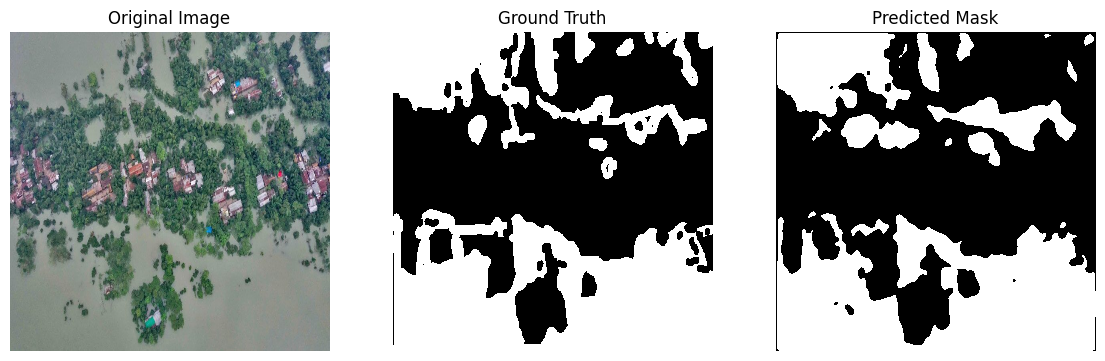

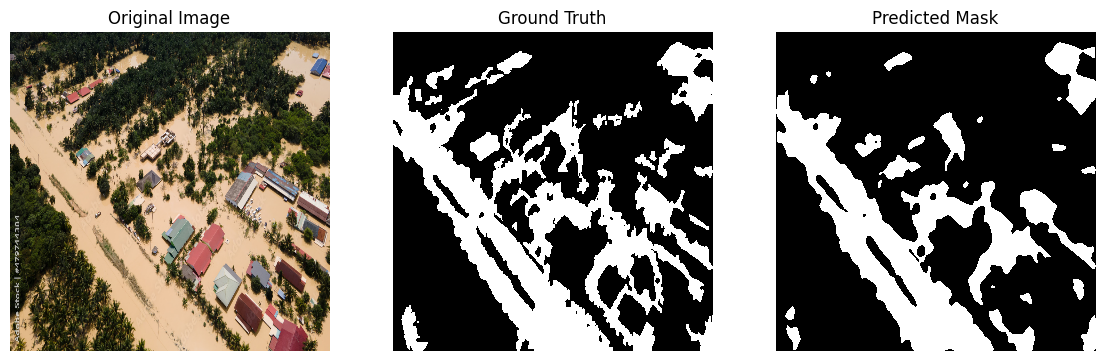

In [23]:
inference(test_dl, model = model, device = device)